In [1]:
import os
path = '/root/bbox_outputs'
filenames = os.listdir(path)
print(len(filenames))
print(filenames[10])

24635
682864661813981184.npz


In [2]:
import numpy as np

for file in filenames:
    data = np.load(os.path.join('/root/bbox_outputs', file), allow_pickle=True)
print(data.files)

['x', 'bbox', 'num_bbox', 'image_h', 'image_w', 'info']


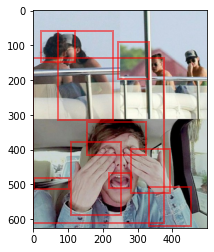

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Load classes
classes = ['__background__']
with open('/hy-tmp/data/objects_vocab.txt') as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open('/hy-tmp/data/attributes_vocab.txt') as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

def draw_box(file_path, npz_path, min_boxes, max_boxes, thresh):
    img = plt.imread(file_path)
    data = np.load(npz_path, allow_pickle=True)
    plt.imshow(img)
    
    info = data['info'].item()
    num_bbox = data['num_bbox']
    bboxes = data['bbox']
    
    objects_conf = info['objects_conf']
    objects_id = info['objects_id']
    attrs_id = info['attrs_id']
    keep_boxes = np.where(objects_conf >= thresh)[0]

    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(objects_conf)[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(objects_conf)[::-1][:max_boxes]

    for i in range(len(keep_boxes)):
        bbox = bboxes[i]
        object = classes[objects_id[i]+1]
        attr = attributes[attrs_id[i]+1]
        plt.gca().add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=2, alpha=0.5)
                )
        # plt.gca().text(bbox[0], bbox[1] - 2,
        #             f'{i} {attr} {object}',
        #             bbox=dict(facecolor='blue', alpha=0.5),
        #             fontsize=10, color='white')
        # print(f'{i} {attr} {object}')

draw_box('/hy-tmp/data/dataset_image/682722242111774720.jpg', '/hy-tmp/data/bbox_outputs/682722242111774720.npz', 10,10,0.4)

In [2]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import pickle

# Load classes
classes = ['__background__']
with open('/hy-tmp/data/objects_vocab.txt') as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open('/hy-tmp/data/attributes_vocab.txt') as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

img_path = '/hy-tmp/data/dataset_image'
bbox_path = '/hy-tmp/data/bbox_outputs'
out_path = '/hy-tmp/data/bbox_sep'

img_list = os.listdir(img_path)
bbox_list = os.listdir(bbox_path)

for i,img in tqdm(enumerate(img_list), total=len(img_list)):
    name = os.path.splitext(img)[0]
    img_jpg = os.path.join(img_path, f'{name}.jpg')
    img_npz = os.path.join(bbox_path, f'{name}.npz')
    
    jpg = Image.open(img_jpg)
    data = np.load(img_npz, allow_pickle=True)
    
    info = data['info'].item()
    box = data['bbox']
    objects_conf = info['objects_conf']
    attrs_conf = info['attrs_conf']
    objects_id = info['objects_id']
    attrs_id = info['attrs_id']

    keep_boxes = np.argsort(objects_conf)[::-1][:10]
    box_list = box[keep_boxes]
    objects_list = objects_id[keep_boxes]
    attrs_list = attrs_id[keep_boxes]
    
    jpg_list = [jpg.crop(box) for box in box_list]

    if not os.path.exists(os.path.join(out_path, f'{name}')):
        os.makedirs(os.path.join(out_path, f'{name}'))
    for j in range(10):
        crop_jpg = jpg_list[j]
        obj = classes[objects_list[j]+1]
        attr = attributes[attrs_list[j]+1]
        crop_name = f'{attr}_{obj}'
        crop_jpg.save(f'{out_path}/{name}/{j}_{crop_name}.jpg')


100%|██████████| 24635/24635 [07:54<00:00, 51.89it/s]


In [3]:
import json
import os
from PIL import Image
import torch
from torchvision import transforms
from pytorch_pretrained_vit import ViT
from torch import nn
from torch.nn import functional as F

device = torch.device("cuda")

in_path = "/hy-tmp/data/bbox_sep"
imgs = os.listdir(in_path)


vit = ViT('B_32', pretrained=True)
print(vit.image_size)
tfms = transforms.Compose([transforms.Resize(vit.image_size), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),])

class my_Vit(nn.Module):
    def __init__(self, model):
        super().__init__()
        self._model = model
    def forward(self, x):
        return self._model(x)
    def features(self, x):
        b, c, fh, fw = x.shape
        x = self._model.patch_embedding(x)  # b,d,gh,gw
        x = x.flatten(2).transpose(1, 2)  # b,gh*gw,d
        if hasattr(self._model, 'class_token'):
            x = torch.cat((self._model.class_token.expand(b, -1, -1), x), dim=1)  # b,gh*gw+1,d
        if hasattr(self._model, 'positional_embedding'): 
            x = self._model.positional_embedding(x)  # b,gh*gw+1,d 
        x = self._model.transformer(x)  # b,gh*gw+1,d
        if hasattr(self._model, 'pre_logits'):
            x = self._model.pre_logits(x)
            x = torch.tanh(x)
        x = self._model.norm(x)[:, 0]
        return x

import pickle
from tqdm import tqdm

model = my_Vit(vit).to(device).eval()

with torch.no_grad():
    dic = {}
    for idx in tqdm(range(len(imgs))):
        name = imgs[idx]
        dic[name] = {}
        path_ = in_path + "/" + name + "/"
        boxes = os.listdir(path_)
        for box in boxes:
            box_name = os.path.splitext(box)[0]
            img = Image.open(path_+box)
            img = tfms(img).unsqueeze(0)
            img = img.to(device)
            outputs = model.features(img).squeeze(0)
            dic[name][box_name] = outputs.cpu()
        '''
        img = Image.open("../data/dataset_image/"+img)
        img = tfms(img).unsqueeze(0)
        outputs = model(img).squeeze(0)
        dic[imgs[idx]] = outputs
        '''
with open("/hy-tmp/data/vit_features.B32.finetuned.pkl",'wb') as fout:
    pickle.dump(dic,fout)

Loaded pretrained weights.
(224, 224)


100%|██████████| 24635/24635 [7:26:48<00:00,  1.09s/it]  


In [1]:
import json
import os
from PIL import Image
import torch
from torchvision import transforms
from pytorch_pretrained_vit import ViT
from torch import nn
from torch.nn import functional as F

device = torch.device("cuda")

in_path = "/root/data/dataset_image"
imgs = os.listdir(in_path)

vit = ViT('B_32', pretrained=True)
print(vit.image_size)
tfms = transforms.Compose([transforms.Resize(vit.image_size), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),])

class my_Vit(nn.Module):
    def __init__(self, model):
        super().__init__()
        self._model = model
    def forward(self, x):
        return self._model(x)
    def features(self, x):
        b, c, fh, fw = x.shape
        x = self._model.patch_embedding(x)  # b,d,gh,gw
        x = x.flatten(2).transpose(1, 2)  # b,gh*gw,d
        if hasattr(self._model, 'class_token'):
            x = torch.cat((self._model.class_token.expand(b, -1, -1), x), dim=1)  # b,gh*gw+1,d
        if hasattr(self._model, 'positional_embedding'): 
            x = self._model.positional_embedding(x)  # b,gh*gw+1,d 
        x = self._model.transformer(x)  # b,gh*gw+1,d
        if hasattr(self._model, 'pre_logits'):
            x = self._model.pre_logits(x)
            x = torch.tanh(x)
        x = self._model.norm(x)[:, 0]
        return x

import pickle
from tqdm import tqdm

model = my_Vit(vit).to(device).eval()

with torch.no_grad():
    dic = {}
    for idx in tqdm(range(len(imgs))):
        name = imgs[idx]
        img = Image.open(in_path + "/" + name)
        img = tfms(img).unsqueeze(0)
        img = img.to(device)
        outputs = model.features(img).squeeze(0)
        dic[name] = outputs.cpu()
        
with open("/root/data/vit_features_universal.B32.finetuned.pkl",'wb') as fout:
    pickle.dump(dic,fout)

Loaded pretrained weights.
(224, 224)


100%|██████████| 24635/24635 [20:59<00:00, 19.56it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/hy-tmp/data/vit_features_universal.B32.finetuned.pkl'

In [3]:
import pickle
with open("/hy-tmp/data/vit_features.B32.finetuned.pkl",'rb') as fin:
    feat = pickle.load(fin)
print(len(feat))
for img in feat:
    print(img, len(feat[img]))
    # for box in feat[img]:
    #     print(box, len(feat[img][box]))

24635
682716753374351360 10
682721949072625664 10
682722242111774720 10
682727470433308672 10
682751920956641280 10
682762265041321989 10
682773510196822016 10
682783114343518208 10
682784347305410560 10
682836685323956224 10
682864661813981184 10
682883715681390593 10
682906033312935936 10
682931582357893120 10
682931696845611008 10
682934584527466496 10
682987076128657408 10
683009023247953921 10
683062203268780032 10
683087755019026432 10
683090662418288640 10
683181977726418945 10
683182680360529920 10
683215653113823232 10
683250958717956097 10
683275769330712577 10
683293152787214336 10
683295117847969793 10
683302904363638784 10
683308322259398658 10
683313760342249472 10
683324835745902592 10
683337444511498240 10
683344545027854336 10
683355503947309056 10
683363557321388032 10
683364611513397248 10
683365234229248004 10
683405203328991232 10
683417001570742274 10
683431160127590400 10
683800787995066368 10
683810612518993920 10
683836032756920320 10
683843373514514432 10
6838